# Make SCF figure
Notebook "copy paste" of `scf_interannual.py`

## Imports:

In [1]:
import os
import sys
import copy
import numpy as np
import xarray as xr
import glob
import math
import matplotlib; #matplotlib.use('TkAgg')
from math import log10, floor
from matplotlib import gridspec
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from mpl_toolkits.basemap import Basemap
from scipy import ndimage
from scipy.interpolate import interp1d
from scipy.stats import linregress, pearsonr
import warnings

## Figure settings: 

In [2]:
plt.rc('font', size = 12)    

## Functions: 

In [3]:
def make_fig4():

    scf = get_sca()

    plot_timeseries(scf)

    return

def get_sca(day1 = 60, day2 = 300, firstyr = 2000, lastyr = 2019):

    # directory to where data is stored
    datadir = '/processed/users/hannah/netcdf/'

    # load in the vegetation map
    vegfile = datadir + 'SvalVeg500_v5.nc'
    dataset = xr.open_dataset(vegfile)

    veg = dataset.vegclass.values

    # define number of years to calculate SCF for
    nyrs = lastyr - firstyr + 1
    ndays = 366
    
    # snow cover fraction = 20 years x 366 days
    scf = np.zeros((nyrs,ndays))
    
    for year in range(firstyr,firstyr + nyrs):
        # find netcdf files for the current year
        dfile = glob.glob(datadir + 'MODIS_SCF_' + \
                          str(year) + '.nc')[0]

        # fill array with the mean snow cover fraction
        # averaged over the whole of Svalbard
        imgs, avscf, nl = read_netcdf(dfile, veg)

        # add time series of averaged snow cover fraction to array
        # use only part of time series from DOY 60-300
        scf[year-firstyr, day1:day2] = avscf[day1:day2]
        
    # force SCF to be 100% before/after of this period
    scf[:,0:day1] = 100.
    scf[:,day2:ndays] = 100

    return scf

def get_mean_sca(scf, vegmap, area = ''):

    # assign a different value to glaciers and water
    scf[vegmap == 32] = 150
    scf[vegmap <= 2] = 200

    if len(area) == 0:
        # number of pixels used in averaging
        nl = len(np.argwhere(scf <= 100.0))
     
        # calculate the mean of all snow cover fraction pixels
        av_sca = np.nanmean(scf[scf <= 100.0])
    elif len(area) > 0:
        ymin = area[0]
        ymax = area[1]
        xmin = area[2]
        xmax = area[3]

        scfarea = scf[ymin:ymax+1, xmin:xmax+1]
        nl = len(np.argwhere(scfarea <= 100.0))
        av_sca = np.nanmean(scfarea[scfarea <= 100.0])
    
    return av_sca, nl

def plot_timeseries(scf, outdir = ''):

    if len(outdir) == 0:
        outdir = '/homes/hannah/'
        
    title_font = {'size':'16', 'color':'black','weight':'normal'}
    
    # x axis labels -> month of year
    mth, mthdoy = mth_labels()
    
    # input data shape
    inpshp = scf.shape
    nyrs = inpshp[0]
    ndays = inpshp[1]

    # Find min,max,mean and plot
    sctime = np.arange(ndays)
    ymean = np.zeros(ndays)
    ymin = np.zeros(ndays)
    ymax = np.zeros(ndays)
    ystd = np.zeros(ndays)
                    
    for n in range(ndays):
        # extract time series at a particular day number for all years
        scat1 = scf[:, n]

        # select values above 0
        lok = np.argwhere(scat1 > 0)
    
        if len(lok) > 0:
            # mean, min and max SCF over all years at DOY n
            ymean[n] = np.nanmean(scat1[scat1 > 0])
            ymin[n] = scat1[scat1 > 0].min()
            ymax[n] = scat1[scat1 > 0].max()

            # calculate standard deviation if number of datapts > 1
            if len(lok) > 1:
                ystd[n] = np.nanstd(scat1[scat1 > 0])
            else:
                ystd[n] = 100
        
    ymin = ndimage.filters.gaussian_filter1d(ymin, 1)    
    ymax = ndimage.filters.gaussian_filter1d(ymax, 1)

    fig, ax1 = plt.subplots(1, figsize=[12,8])
    ax1.plot(sctime, ymean, label = 'Mean')

    # fill area between ymin and ymax
    ax1.fill_between(sctime, ymin, ymax, where = ymax >= ymin, \
                     facecolor='gray', interpolate=True)

    # get color list
    clist = colors(ncols = nyrs)
    
    # Plot all years with legends
    for n1 in range(nyrs):
        scat1 = scf[n1,:]
        lok = np.argwhere(scat1 > 0)

        if len(lok) > 1:
            sl = scat1[scat1 > 0]
            sm = ndimage.filters.gaussian_filter1d(sl, 1)
            ax1.plot(sctime[scat1 > 0],sm, label = str(n1 + 2000),\
                     color = clist[n1])

    # plot x axis with 12 ticks and labels 
    ax1.set_xlim(sctime.min(), sctime.max())
    ax1.set_ylim(0,105.)

    tit = 'Total snow cover fraction (% of land area excl. glaciers)'
    ax1.set_xticks(mthdoy[:])
    ax1.set_xticklabels(mth)
    ax1.set_xlabel('Month', **title_font)
    ax1.set_ylabel('SCF, %', **title_font)
    ax1.set_title(tit, **title_font)
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid('on')
        
    #fname = outdir + 'SCF_ts.jpeg'
    #plt.savefig(fname, dpi = 400, bbox_inches='tight')
    
    #plt.close()
    
    return

def mth_labels(startmth = 1, nmth = 12):

    if (startmth == 1) and (nmth == 12):
        mth = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',\
               'Sep', 'Oct', 'Nov', 'Dec']

        daysinmth = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
        daysinmth = np.asarray(daysinmth, dtype='float32')
        
        # DOY corresponding to month start
        mthdoy = np.zeros(nmth)

        for i in range(1,len(mthdoy)+1):
            mthdoy[i-1] = np.sum(daysinmth[0:i])

    # time series for ice concentration from Sept to end of June
    if (startmth == 9) and (nmth == 10):
        mth = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr',\
               'May', 'Jun']

        daysinmth = [0, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30]
        daysinmth = np.asarray(daysinmth, dtype='float32')
        
        # DOY corresponding to month start
        mthdoy = np.zeros(nmth)

        for i in range(1,len(mthdoy)+1):
            mthdoy[i-1] = np.sum(daysinmth[0:i])
        

    return mth, mthdoy

def colors(ncols = 20):

    # make a list of up to 20 colors to use for curve plotting
    cols = ['darkred','red','coral','sandybrown','moccasin','gold',\
            'yellow','lemonchiffon','greenyellow','limegreen','darkgreen',\
            'turquoise','aqua','skyblue','dodgerblue','mediumblue',\
            'blueviolet','violet','mediumvioletred','pink']

    clist = []
    
    for i in range(ncols):
        clist.append(cols[i])

    return clist

def read_netcdf(df, veg):
    
    # make a dataset from contents
    dataset = xr.open_dataset(df)

    lat = dataset.lat.values
    lon = dataset.lon.values
        
    # view and extract properties of the dataset
    # variables are snowfr, time, lat and lon
    snowfraction = dataset.snowfr.values

    # snow fraction is stored as a byte array in the NetCDF file
    # convert to float type to do the averaging
    snfr = snowfraction.astype('float32')

    # script to read in the output files and check/plot out the data
    ndays = snfr.shape[0]
    meanscf = np.zeros(ndays)
    
    # for each day in snow cover map get the mean SCF for entire Svalbard
    for i in range(ndays):
        # extract snow map for a single day
        snfr_day = snfr[i,:,:]
        av_scf, nl = get_mean_sca(snfr_day, veg)
        meanscf[i] = av_scf

    return snfr, meanscf, nl

## Make figure: 

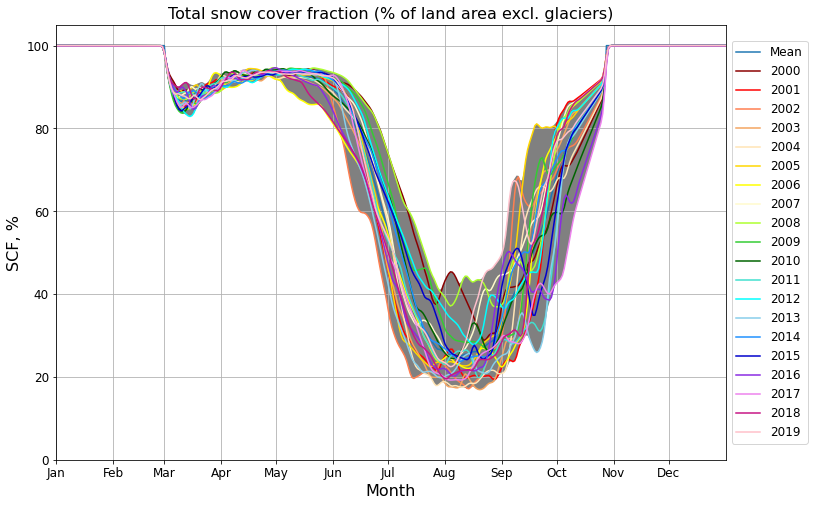

In [4]:
make_fig4()